<a href="https://colab.research.google.com/github/mike1336git/colab_notebook/blob/main/with_js/js042_bccMetalAFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### simulator( html + css + js ) + control( python )

In [3]:
#@title js042_bccMetalAFS / def exec_html_js() ... exec me first
#
#  Copyright(C) 2023-2024 Mitsuru Ikeuchi
#  home page: https://mike1336.web.fc2.com/index.html
#  Released under the MIT license ( https://opensource.org/licenses/MIT )
#
#  ver 0.0.0  2023.09.29 created,  last updated on 2025.09.22
#

# def exec_html_js()

import IPython
from IPython.display import display, HTML
from google.colab.output import eval_js

def exec_html_js():
  htm = HTML('''


<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<title>js042_bccMetalAFS</title>
<script type="text/javascript">

// %%%%%%%%%%%%%%%%%%%%  javaScript  %%%%%%%%%%%%%%%%%%%%

'use strict';

/* --------------------
//
//  js042_bccMetalAFS
//    Copyright(C) 2017-2023 Mitsuru Ikeuchi
//    Released under the MIT license ( https://opensource.org/licenses/MIT )
//
//    ver 0.0.0  2017.06.19 created, last updated on 2018.11.19
//    ver 0.0.1  2019.01.17 v1, last updated on 2021.06.02
//    ver 0.0.2  2021.11.01 v2, last updated on 2021.11.01
//    ver 0.0.3  2023.03.12 v3, last updated on 2023.08.24
//
// --------------------  molecular dynamics 3D - Finnis-Sinclair potential + Ackland correction
//
// - method: velocity Verlet Algorithm
//      (1) vi = vi + (Fi/mi)*(0.5dt)
//      (2) ri = ri + vi*dt
//      (3) calculation Fi <- {r1,r2,...,rn} Fi=sum(Fij,j=1 to n),Fij=F(ri-rj)
//      (4) vi = vi + (Fi/mi)*(0.5dt)
//      (5) goto (1)
//
// - Finnis-Sinclair potential + Ackland correction
//     original paper
//       M. W. Finnis and J. E. Sinclair ; Phil. Mag. A, Vol. 50, No. 1, p.45-55 (1984)
//     core correction
//       G. J. Ackland and R. Thetford ; Phil. Mag. A, Vol. 56, No. 1, p.15-30 (1987)
//
//   total energy : E_tot
//     E_tot = (1/2) Sum[ V(r_ij), {i,j} ] - Sum[ F(rho_i), {i} ]
//
//   pair-potential V(r_ij)
//     V(r_ij) = (r-c)^2 (c0 + c1 r + c2 r^2), (r<=c else 0)
//   (Ackland core correction)
//     V(r_ij) = (r-c)^2 (c0 + c1 r + c2 r^2) + B (b0-r)^3 exp(-alpha r), (r<b0<c)
//
//   n-body (embedding) function F(rho)
//     F(rho) = A sqrt(rho)
//   electronic density at host atom i
//     rho_i = Sum[ fai(r_ij), {j} ]
//
//   electronic density function
//     fai(r) = (r-d)^2 (r<=d else 0)
//   (Ackland correction)
//     fai(r) = (r-d)^2 + B(r-d)^3/d (r<=d else 0)
//
//   effective pair-potential V_eff(r)
//     (F"=0 apploximation)
//     V_eff(r) = V(r) - 2 A F' fai(r)
//     ( F' = d F(rho)/drho )
//
//   force = -dV_eff/dr
//         = -dV(r)/dr + 2 A fpi dfai(r)/dr,  fpi = dF/drho
//
// --------------------
*/

const bccMetalAFS = (function(){ // ====================  bccMetalAFS Module  ====================

	const g_AMU = 1.66053904e-27;					// (kg) atomic mass unit
	const g_kB = 1.380649e-23;						// (J/K) Boltzmann's constant
	const g_EE = 1.602176634e-19;					// (C) electron charge, energy : 1(eV) = EE(J)
	const g_nMax = 8000;

	let g_MAT1 = 2;									// kind of particles  0:W 1:Mo 2:Fe 3:Cr 4:Ta 5:Nb 6:V
	let g_nParticles =1000;							// number of particles
	let g_sysTime = 0.0;							// (s) system time
	let g_timeStep =  1.0*1.0e-15;					// (s) time step dt
	let g_xMax = 4.0E-9;							// (m) x-Box size
	let g_yMax = 4.0E-9;							// (m) y-Box size
	let g_zMax = 4.0E-9;							// (m) z-Box size
	let g_Nsx = Math.floor(g_xMax/5e-10)+1; 		// use pre-registration section[Nsx][Nsy][Nsz]
	let g_Nsy = Math.floor(g_xMax/5e-10)+1; 		// use pre-registration section[Nsx][Nsy][Nsz]
	let g_Nsz = Math.floor(g_xMax/5e-10)+1; 		// use pre-registration section[Nsx][Nsy][Nsz]

	const g_xx = dim1( g_nMax );					// (m) x-component of i-th particle position
	const g_yy = dim1( g_nMax );					// (m) y-component of i-th particle position
	const g_zz = dim1( g_nMax );					// (m) z-component of i-th particle position
	const g_vx = dim1( g_nMax );					// (m/s) x-component of i-th particle velocity
	const g_vy = dim1( g_nMax );					// (m/s) y-component of i-th particle velocity
	const g_vz = dim1( g_nMax );					// (m/s) z-component of i-th particle velocity
	const g_ffx = dim1( g_nMax );					// (N) x-component of total force applied i-th particle
	const g_ffy = dim1( g_nMax );					// (N) y-component of total force applied i-th particle
	const g_ffz = dim1( g_nMax );					// (N) z-component of total force applied i-th particle
	//const g_mas = dim1( g_nMax );					// (kg) mass of i-th particle
	//const g_kind = dimInt1( g_nMax );				// kind of i-th particle
	const g_reg = dimInt2( g_nMax, 50 );			// reg[i][0]:total number of particles proximity i-th particle
													// reg[i][j]:particle number of proximity i-th particle, (j>0)
	const g_rijReg = dim2( g_nMax, 50 );			// memory of rij(distance of i-th particle to j-th particle)
	const g_regNr = dimInt2( g_nMax, 100 );			// regNr[i][0]:total number of particles near i-th particle
													// regNr[i][j]:particle number near i-th particle, (j>0)
	const g_section = dimInt4( g_Nsx, g_Nsy, g_Nsz, 50 ); // section[i][j][k][0]: total number of particles in section
														  // section[i][j][k][ip]: k-th particle number in section

	function dim1( n ) {
		return new Float64Array( n );
	}

	function dimInt1( n ) {
		return new Int32Array( n );
	}

	function dim2( ni, nj ) {
		let a = [];
		for (let i=0; i<ni; i++) {
			a[i] = new Float64Array( nj );
		}
		return a;
	}

	function dimInt2( ni, nj ) {
		let a = [];
		for (let i=0; i<ni; i++) {
			a[i] = new Int32Array( nj );
		}
		return a;
	}

	function dimInt3( ni, nj, nk ) {
		let a = [];
		for (let i=0; i<ni; i++) {
			a[i] = [];
			for (let j=0; j<nj; j++) {
				a[i][j] =  new Int32Array( nk );
			}
		}
		return a;
	}

	function dimInt4( ni, nj, nk, nl ) {
		let a = [];
		for (let i=0; i<ni; i++) {
			a[i] = [];
			for (let j=0; j<nj; j++) {
				a[i][j] = [];
				for (let k=0; k<nk; k++) {
					a[i][j][k] = new Int32Array( nl );
				}
			}
		}
		return a;
	}


	// --------------------  Finnis-Sinclair potential + Ackland correction data  --------------------

	// F-S potential parameter
	let g_FSmass = 183.85*g_AMU;	//   mass(kg)
	let g_FSd = 4.400224;			//   d(A)
	let g_FSA = 1.896373;			//   A(eV)
	let g_FSb = 0.0;				//   b
	let g_FSc = 3.25;				//   c(A)
	let g_FSc0 = 47.1346499;		//   c0
	let g_FSc1 = -33.7665655;		//   c1
	let g_FSc2 = 6.2541999;			//   c2
	let g_FSlattice = 3.16*1.0e-10;	//   lattice constant(m)

	// Ackland correction parameter
	let g_FSbb = 90.3;				//   B(eV/A^3)
	let g_FSalpha = 1.2;			//   alpha
	let g_FSb0 = 2.7411;			//   b0(A)

	const g_FS = [
		// 0 mass      1 d      2 A(eV)  3 b  4 c  5 c0      6 c1        7 c2      8 a   9 factor 10 str
		[183.85 *g_AMU,4.400224,1.896373,0.0,3.25,47.1346499,-33.7665655, 6.2541999, 3.16, 1.00, "W" ],  // 0
		[ 95.94 *g_AMU,4.114825,1.887117,0.0,3.25,43.4475218,-31.9332978, 6.0804249, 3.15, 1.00, "Mo"],  // 1
		[ 55.847*g_AMU,3.569745,1.828905,1.8,3.40, 1.2371147, -0.3592185,-0.0385607, 2.87, 1.00, "Fe"],  // 2
		[ 51.996*g_AMU,3.915720,1.453418,1.8,2.90,29.1429813,-23.3975027, 4.7578297, 2.88, 1.00, "Cr"],  // 3
		[180.948*g_AMU,4.076980,2.591061,0.0,4.20, 1.2157373,  0.0271471,-0.1217350, 3.30, 1.00, "Ta"],  // 4
		[ 92.906*g_AMU,3.915354,3.013789,0.0,4.20,-1.5640104,  2.0055779,-0.4663764, 3.30, 0.99, "Nb"],  // 5
		[ 50.942*g_AMU,3.692767,2.010637,0.0,3.80,-0.8816318,  1.4907756,-0.3976370, 3.03, 1.00, "V" ] ];// 6

	const g_Ackland = [
		//0 B(eV/A3)  1 alpha   2 b0(A)
		[   90.3,     1.2,      2.7411 ],  // 0 W
		[ 1223.0,     3.9,      2.7255 ],  // 1 Mo
		[    0.0,     1.0,      0.0    ],  // 2 Fe
		[    0.0,     1.0,      0.0    ],  // 3 Cr
		[   91.0,     1.05,     2.8629 ],  // 4 Ta
		[   48.0,     0.8,      2.8585 ],  // 5 Nb
		[   23.0,     0.5,      2.6320 ] ];// 6 V

	const g_rCollision = [];		// (m) bond[kind]/2^(1/6), (as collision radius of L-J potential)
	const g_rBond = [];				// (m) bond length == 2.0*g_rBond[kind]
	const g_massOf = [];			// (kg) massOf[kind] : mass of kind
	const g_strOf = [];				// strOf[kind] : string of kind, such as "Fe"
	const g_colorOf = [];			// colorOf[kind] : color of kind

	(function() {
		const n=g_FS.length;
		for (let i=0; i<n; i++) {
			g_rCollision[i] = g_FS[i][8]*1.0e-10*Math.sqrt(3)/4.0/1.12246;
			g_rBond[i] = g_FS[i][8]*1.0e-10*Math.sqrt(3)/4.0;
			g_massOf[i] = g_FS[i][0];
			g_strOf[i] = g_FS[i][10];
			g_colorOf[i] = "";
		}
	}());

	function setFSParam(m1) {
		g_FSmass = g_FS[m1][0];
		g_FSd = g_FS[m1][1];
		g_FSA = g_FS[m1][2];
		g_FSb = g_FS[m1][3];
		g_FSc = g_FS[m1][4];
		g_FSc0 = g_FS[m1][5];
		g_FSc1 = g_FS[m1][6];
		g_FSc2 = g_FS[m1][7];
		g_FSlattice = g_FS[m1][8]*1.0e-10*g_FS[m1][9];

		g_FSbb = g_Ackland[m1][0];
		g_FSalpha = g_Ackland[m1][1];
		g_FSb0 = g_Ackland[m1][2];
	}


	// --------------------  set initial condition  --------------------

	function setInitialCondition( material, BoxSizeInNM, contTemp ) {
		g_sysTime = 0.0;
		g_xMax = BoxSizeInNM*1.0e-9;
		g_yMax = BoxSizeInNM*1.0e-9;
		g_zMax = BoxSizeInNM*1.0e-9;
		g_Nsx = Math.floor(g_xMax/5e-10)+1;
		g_Nsy = Math.floor(g_xMax/5e-10)+1;
		g_Nsz = Math.floor(g_xMax/5e-10)+1;
		g_MAT1 = material;
		setFSParam(g_MAT1);
		g_nParticles = setBccCrystal(0,8);
		ajustVelocity(contTemp);
	}

	function setBccCrystal(ii,n) {
		const a = g_FSlattice;
		const s = 0.5*(g_xMax - a*n)+0.25*a;
		let i = ii;
		for (let ix=0; ix<n; ix++) {
			for (let iy=0; iy<n; iy++) {
				for (let iz=0; iz<n; iz++) {
					setParticle(i,a*ix+s,a*iy+s,a*iz+s);
					i++;
					setParticle(i,a*ix+0.5*a+s,a*iy+0.5*a+s,a*iz+0.5*a+s);
					i++;
				}
			}
		}
		return i;
	}

	function setParticle(i,x,y,z) {
		g_xx[i] = x;
		g_yy[i] = y;
		g_zz[i] = z;
		g_vx[i] = 200.0*normalRandom3();
		g_vy[i] = 200.0*normalRandom3();
		g_vz[i] = 200.0*normalRandom3();
		g_ffx[i] = 0.0;
		g_ffy[i] = 0.0;
		g_ffz[i] = 0.0;
	}

	// normal distributed random number: -3.0 <= normalRandom3() < 3.0
	function normalRandom3() {
		return (Math.random()+Math.random()+Math.random()+Math.random()+Math.random()+Math.random()-3.0);
	}


	// --------------------  time evolution  --------------------

	function timeEvolution( tempMode, contTemp ) {
		if (tempMode==1) ajustVelocity(contTemp);
		regNear();
		for (let i=0; i<10; i++) {
			moveParticles(g_timeStep);
			g_sysTime += g_timeStep;
		}
	}

	function moveParticles(dt) {
		const nn = g_nParticles, dtv2 = dt/2.0;
		const a = dtv2/g_FSmass;
		for (let i=0; i<nn; i++) {
			g_vx[i] += a*g_ffx[i];
			g_vy[i] += a*g_ffy[i];
			g_vz[i] += a*g_ffz[i];
			g_xx[i] += g_vx[i]*dt;
			g_yy[i] += g_vy[i]*dt;
			g_zz[i] += g_vz[i]*dt;
		}
		setForce();
		for (let i=0; i<nn; i++) {
			g_vx[i] += a*g_ffx[i];
			g_vy[i] += a*g_ffy[i];
			g_vz[i] += a*g_ffz[i];
		}
	}

	function setForce() {
		const nn = g_nParticles, s05 = 0.5*3.418e-10; // Ar sigma=3.418e-10
		for (let i=0; i<nn; i++) {
			g_ffx[i] = 0.0;
			g_ffy[i] = 0.0;
			g_ffz[i] = 0.0;
		}
		let xxvir = 0.0, yyvir = 0.0, zzvir = 0.0;
		let xyvir = 0.0, xzvir = 0.0, yzvir = 0.0;

		regProximity();
		for (let i=0; i<nn; i++) {
			const fpi = dFdroh(i);
			for (let k=1; k<g_reg[i][0]; k++) {
				const j = g_reg[i][k];
				if (j>i) {
					const xij = g_xx[i] - g_xx[j];
					const yij = g_yy[i] - g_yy[j];
					const zij = g_zz[i] - g_zz[j];

					const rij = g_rijReg[i][k];
					const f = forceAFS(rij,fpi);
					const fxij = f*xij/rij;
					const fyij = f*yij/rij;
					const fzij = f*zij/rij;

					g_ffx[i] +=  fxij;
					g_ffy[i] +=  fyij;
					g_ffz[i] +=  fzij;
					g_ffx[j] += -fxij;
					g_ffy[j] += -fyij;
					g_ffz[j] += -fzij;
				}
			}
		}
		for (let i=0; i<nn; i++) {
			g_ffx[i] += boundaryForce(g_xx[i]+s05)+boundaryForce(g_xx[i]-g_xMax-s05);
			g_ffy[i] += boundaryForce(g_yy[i]+s05)+boundaryForce(g_yy[i]-g_yMax-s05);
			g_ffz[i] += boundaryForce(g_zz[i]+s05)+boundaryForce(g_zz[i]-g_zMax-s05);
		}
	}

	function boundaryForce(r) {
		const ri = (3.418e-10/r);
		const r6 = ri*ri*ri*ri*ri*ri;
		return (24.0*0.5*1.711e-21*r6*(2.0*r6-1.0)/r);
	}

	//--- registration of near atoms

	function regNear() {
		const nn=g_nParticles, nsx=g_Nsx, nsy=g_Nsy, nsz=g_Nsz;
		preRegistration();
		let rrg = g_FSc*1.0e-10;
		if (rrg<g_FSd*1.0e-10) {
			rrg = g_FSd*1.0e-10;
		}
		rrg += 5000.0*g_timeStep*10.0;
		const rrg2 = rrg*rrg;
		for (let ip=0; ip<nn; ip++) {
			let kp = 1;
			let i0 = Math.floor(nsx*(g_xx[ip]-rrg)/g_xMax); if (i0<0) i0 = 0;
			let i1 = Math.floor(nsx*(g_xx[ip]+rrg)/g_xMax); if (i1>=nsx) i1 = nsx-1;
			let j0 = Math.floor(nsy*(g_yy[ip]-rrg)/g_yMax); if (j0<0) j0 = 0;
			let j1 = Math.floor(nsy*(g_yy[ip]+rrg)/g_yMax); if (j1>=nsy) j1 = nsy-1;
			let k0 = Math.floor(nsz*(g_zz[ip]-rrg)/g_zMax); if (k0<0) k0 = 0;
			let k1 = Math.floor(nsz*(g_zz[ip]+rrg)/g_zMax); if (k1>=nsz) k1 = nsz-1;
			for (let i=i0; i<=i1; i++) {
				for (let j=j0; j<=j1; j++) {
					for (let k=k0; k<=k1; k++) {
						for (let iq=1; iq<=g_section[i][j][k][0]; iq++) {
							const jp = g_section[i][j][k][iq];
							if (jp!=ip) {
								const r2 = distance2(ip, jp);
								if (r2<rrg2) {
									g_regNr[ip][kp] = jp;
									kp += 1;
								}
							}
						}
					}
				}
			}
			g_regNr[ip][0] = kp;
		}
	}

	function distance2(i,j) {
		const xij = g_xx[i]-g_xx[j], yij = g_yy[i]-g_yy[j], zij = g_zz[i]-g_zz[j];
		return xij*xij+yij*yij+zij*zij;
	}

	// pre-registration
	//   section[i][j][k][0] : number of particles in section (i,j,k)
	//   set section[i][j][k][ip] : ip-th particle index in section (i,j,k)
	//     (ip = 1,..., section[i][j][k][0])
	function preRegistration() {
		const nn=g_nParticles, nsx=g_Nsx, nsy=g_Nsy, nsz=g_Nsz;
		for (let i=0; i<nsx; i++) {
			for (let j=0; j<nsy; j++) {
				for (let k=0; k<nsz; k++) {
					g_section[i][j][k][0] = 0;
				}
			}
		}
		for (let ip=0; ip<nn; ip++) {
			let i = Math.floor(nsx*g_xx[ip]/g_xMax); if (i>=nsx) i = nsx-1;
			let j = Math.floor(nsy*g_yy[ip]/g_yMax); if (j>=nsy) j = nsy-1;
			let k = Math.floor(nsz*g_zz[ip]/g_zMax); if (k>=nsz) k = nsz-1;
			const iq = g_section[i][j][k][0]+1;
			g_section[i][j][k][0] = iq;
			g_section[i][j][k][iq] = ip;
		}
	}

	// registration proximity
	//   regNr[i][0] : number of proximity regNr[i][k] : i-th particle index k = 1,...,regNr[i][0])
	//   rijReg[i][k] : distance(i,k)
	//
	function regProximity() {
		const nn=g_nParticles;
		let rrg = g_FSc*1.0e-10;
		if (rrg<g_FSd*1.0e-10) {
			rrg = g_FSd*1.0e-10;
		}
		const rrg2 = rrg*rrg;
		for (let i=0; i<nn; i++) {
			let k = 1;
			for (let jj=1; jj<g_regNr[i][0]; jj++) {
				const j = g_regNr[i][jj];
				const r2 = distance2(i,j);
				if (r2<rrg2) {
					g_reg[i][k] = j;
					g_rijReg[i][k] = Math.sqrt(r2);
					k += 1;
				}
			}
			g_reg[i][0] = k;
		}
	}

	//--- force ( Finnis-Sinclair potential + Ackland correction )

	function forceAFS(r,fpi) {
		const ra = r*1.0e10;
		const rt = -dpotVdr(ra)+2.0*g_FSA*fpi*dfaidr(ra);
		return ( rt*g_EE/1.0e-10 );
	}

	function dFdroh(i) {
		const rh = roh(i);
		let ret = 0.0;
		if (rh>0.0) {
			ret = 0.5*Math.sqrt(1.0/rh);
		}
		return ret;
	}

	function roh(i) {
		let s=0.0;
		for (let k=1; k<g_reg[i][0]; k++) {
			const j = g_reg[i][k];
			s += fai( g_rijReg[i][k]*1.0e10 );
		}
		return s;
	}

	function potV(r) {
		if (r<g_FSc) {
			if (r>=g_FSb0) {
				return (r-g_FSc)*(r-g_FSc)*(g_FSc0+g_FSc1*r+g_FSc2*r*r);
			} else {
				return ( (r-g_FSc)*(r-g_FSc)*(g_FSc0+g_FSc1*r+g_FSc2*r*r)
							+ g_FSbb*(g_FSb0-r)*(g_FSb0-r)*(g_FSb0-r)*Math.exp(-g_FSalpha*r) );
			}
		} else {
			return 0.0;
		}
	}

	function dpotVdr(r) {
		if (r<g_FSc) {
			if (r>=g_FSb0) {
				return 2.0*(r-g_FSc)*(g_FSc0+g_FSc1*r+g_FSc2*r*r)+(r-g_FSc)*(r-g_FSc)*(g_FSc1+2.0*g_FSc2*r);
			} else {
				return ( 2.0*(r-g_FSc)*(g_FSc0+g_FSc1*r+g_FSc2*r*r)+(r-g_FSc)*(r-g_FSc)*(g_FSc1+2.0*g_FSc2*r)
							+ g_FSbb*(g_FSb0-r)*(g_FSb0-r)*Math.exp(-g_FSalpha*r)*(-3.0-g_FSalpha*(g_FSb0-r)) );
			}
		} else {
			return 0.0;
		}
	}

	function fai(r) {

		if (r<g_FSd) {
			return ( (r-g_FSd)*(r-g_FSd)*(1.0+g_FSb*(r-g_FSd)/g_FSd) );
		} else {
			return 0.0;
		}
	}

	function dfaidr(r) {
		if (r<g_FSd) {
			return ( 2.0*(r-g_FSd)+3.0*g_FSb*(r-g_FSd)*(r-g_FSd)/g_FSd );
		} else {
			return 0.0;
		}
	}


	// --------------------  utility  --------------------

	function systemTemperature() {
		const nn=g_nParticles;
		let ek=0.0;  //kinetic energy (J)
		for (let i=0; i<nn; i++) {
			ek = ek + 0.5*g_FSmass*(g_vx[i]*g_vx[i]+g_vy[i]*g_vy[i]+g_vz[i]*g_vz[i]);
		}
		return 2.0*ek/(3.0*nn*g_kB); //2D: E/N=kT, 3D: E/N=(3/2)kT
	}

	function ajustVelocity(temp) {
		const nn=g_nParticles;
		const a = Math.sqrt(temp/systemTemperature());
		for (let i=0; i<nn; i++) {
			g_vx[i] = a*g_vx[i];
			g_vy[i] = a*g_vy[i];
			g_vz[i] = a*g_vz[i];
		}
	}

	function regMax() {
		const nn=g_nParticles;
		let m=0;
		for (let i=0; i<nn; i++) {
			if (g_reg[i][0]>m) {
				m = g_reg[i][0];
			}
		}
		return m;
	}


	// --------------------  public  --------------------

	return {
		init:			setInitialCondition,	// setInitialCondition( material, boxSizeInNM, contTemp)
		evolve:			timeEvolution,			// timeEvolution( tempMode, contTemp )

		setTemp:		ajustVelocity,			// ajustVelocity( temp )

		getSysParam:	function() { return [ g_nParticles, g_timeStep, g_xMax, g_yMax, g_zMax, g_MAT1 ]; },
		getNow:			function() { return [ g_sysTime, systemTemperature(), g_strOf[g_MAT1] ]; },
		getrBond:		function(kind) { return g_rBond[kind]; },
		getNearList:	function(i) { return g_reg[i]; },
		getPosition:	function(i) { return [ g_xx[i], g_yy[i], g_zz[i] ]; },
		getVelocity:	function(i) { return [ g_vx[i], g_vy[i], g_vz[i] ]; },
		getForce:		function(i) { return [ g_ffx[i], g_ffy[i], g_ffz[i] ]; },
	};

})(); // ====================  bccMetalAFS end  ====================


const js042 = (function(){ // ====================  js Module  ====================

	const theModule = bccMetalAFS;
	const xCanvasSize = 480;	// in pixel
	const yCanvasSize = 480;	// in pixel
	let canvas;
	let ctx;

	let v_theme = 2; // = kind  0:W, 1:Mo, 2:Fe, 3:Cr, 4:Ta, 5:Nb, 6:V
	let v_BoxSizeInNM = 3.2;
	let v_tempMode = 1;
	let v_contTemp = 200.0;

	let p_nParticles, p_timeStep, p_xMax, p_yMax, p_zMax, p_kind1; // = theModule.getSysParam();
	let sysTime, sysTemp, kindStr;
	let nowData = [];
	let xxList = [];
	let yyList = [];
	let zzList = [];
	let vxList = [];
	let vyList = [];
	let vzList = [];

	let nCalc = 1;
	let dispMode = 0;
	let resetFlag = true;
	let pauseFlag = false;
	let stepFlag = false;

	let breakFlag = false;
	let perticleFlag = true;


	function main() {
		resetFlag = true;
		setCanvas( 'canvas_box', xCanvasSize, yCanvasSize );
		initDom();

		animate();

		function setCanvas( canvasID, width, height ) {
			canvas = document.getElementById( canvasID );
			canvas.width  = width;
			canvas.height = height;
			ctx = canvas.getContext('2d');
			ctx.font = "16px 'sans-serif'";
			ctx.textBaseline = "bottom";
			ctx.textAlign = "left";
			ctx.lineWidth = 1;
			g3d.setMouseOnCanvas( canvas ); // 3D graphics
		}
	}


	function animate() {
    if ( breakFlag ) return;

		if ( resetFlag ) {
			resetFlag = false;
			theModule.init( v_theme, v_BoxSizeInNM, v_contTemp ); // ( nn, BoxSizeInNM, contTemp )
			[ p_nParticles, p_timeStep, p_xMax, p_yMax, p_zMax, p_kind1 ] = theModule.getSysParam();
			// g3d.init( nParticles, xMax, yMax, zMax, xCanvasSize, yCanvasSize, xBoxSize, yShift )
			g3d.init( p_nParticles, p_xMax, p_yMax, p_zMax, xCanvasSize, yCanvasSize, 300, 20 );
			perticleFlag = true;
		}

		if ( !pauseFlag ) {
			for(let i=0; i<nCalc; i++ ) {
				theModule.evolve( v_tempMode,v_contTemp );
			}
		} else if ( pauseFlag && stepFlag ) {
			stepFlag = false;
			theModule.evolve( v_tempMode, v_contTemp );
		}

		draw( ctx, dispMode );

		if ( perticleFlag ) setParticlesData();

		requestAnimationFrame( animate );
	}

  function setParticlesData() {
		nowData = [ sysTime, sysTemp, v_theme ]; // v_theme = kind
    for (let i=0; i<p_nParticles; i++) {
			let x, y, z, vx, vy, vz;
			[ x, y, z ] = theModule.getPosition(i);
			xxList[i] = x;
			yyList[i] = y;
			zzList[i] = z;
			[ vx, vy, vz ] = theModule.getVelocity(i);
			vxList[i] = vx;
			vyList[i] = vy;
			vzList[i] = vz;

		}
	}


	// --------------------  draw  --------------------

	const ballColorData = [
			/*0:W */ [ 0x44, 0x44, 0xff ], /*1:Mo*/ [ 0x00, 0x88, 0xff ], /*2:Fe*/ [ 0x00, 0xff, 0xff ],
			/*3:Cr*/ [ 0x00, 0xff, 0x88 ], /*4:Ta*/ [ 0x00, 0xff, 0x00 ], /*5:Nb*/ [ 0x66, 0xff, 0x00 ],
			/*6:V */ [ 0xbb, 0xff, 0x00 ] ];

	function draw( ctx, dispMode ) {
		const yTextPos= 430;

		ctx.clearRect(0, 0, xCanvasSize, yCanvasSize);

		if ( dispMode==0 ) {
			// draw3D( ctx, nParticles, ballScale, bondFlag )
			draw3D( ctx, p_nParticles, 1.0, false );
		} else if ( dispMode==1 ) {
			draw3D( ctx, p_nParticles, 0.4, false );
		} else if ( dispMode==2 ) {
			draw3D( ctx, p_nParticles, 0.4, true );
		} else if ( dispMode==3 ) {
			draw3D( ctx, p_nParticles, 0.0, true );
		}

		// caption
		[ sysTime, sysTemp, kindStr ] = theModule.getNow();
		ctx.fillStyle = "#888888";
		ctx.fillText(`time = ${(sysTime*1.0e12).toFixed(1)} (ps)`, 20, yTextPos);
		ctx.fillText(`Temp = ${sysTemp.toFixed(1)} (K)`, 260, yTextPos);
		ctx.fillText(`material : ${kindStr}, N = ${p_nParticles}`, 20, yTextPos+20);
		ctx.fillText(`control Temp = ${v_contTemp} (K)`, 260, yTextPos+20);
		ctx.fillText(`box = ${(p_xMax*1.0e9).toFixed(1)}x${(p_yMax*1.0e9).toFixed(1)}x${(p_zMax*1.0e9).toFixed(1)} (nm)`,
						20, yTextPos+40);
		//ctx.fillText("Energy = "+(kineticEnergy+potentialEnergy).toExponential(4)+" (J)", 240, yTextPos+40);

	}

	function draw3D( ctx, nParticles, ballScale, bondFlag ) {
		let sc, xp, yp; [ sc, xp, yp ] = g3d.scxpypFunc(); // g3d sc, xp, yp
		const nn = nParticles, kind = p_kind1;
		const rBond = theModule.getrBond(kind);

		g3d.set3DRotatedObjects(0.0); //(rotateRateOfAyInDegree) eg. 0.0 or 0.5
		g3d.plotFarEdge(ctx, sc,xp,yp,"#444400"); // dark yellow
		for (let i=0; i<nn; i++) {
			const j = g3d.srtzix[i];
			//const zr = (g3d.ppz[j]/g_zMax+1.23)/3.0; // -0.73 < g3d.ppz[j]/g_zMax < 1.73
			const zr = (g3d.ppz[j]/g_zMax+1.0)/2.73; // -0.73 < g3d.ppz[j]/g_zMax < 1.73
			const col = ballColor( kind, zr );
			const x = g3d.ppx[j]*sc+xp, y = g3d.ppy[j]*sc+yp, r = rBond*sc*ballScale;
			if ( r>0.0 ) {
				g3d.drawDisc( ctx, x, y, r, ballColor( kind, zr ) );
				g3d.strokeCircle( ctx, x, y, r, ballColor( kind, zr*0.7 ) );
			}
			if ( bondFlag ) {
				const reg = theModule.getNearList(j);
				const d0 = rBond*2;
				const n = reg[0];
				let x1, y1, z1; [ x1, y1, z1 ] = theModule.getPosition(j);
				for (let k=1; k<n; k++) {
					const jj = reg[k];
					let x2, y2, z2; [ x2, y2, z2 ] = theModule.getPosition(jj);
					const d = Math.sqrt( (x1-x2)*(x1-x2) + (y1-y2)*(y1-y2) + (z1-z2)*(z1-z2) );
					if ( d<d0*1.2 ) {
						const hue = Math.floor(18120+600*(d/d0-1)) % 360;
						g3d.drawLine(ctx, x, y, g3d.ppx[jj]*sc+xp, g3d.ppy[jj]*sc+yp, `hsl(${hue},100%,50%)` );
					}
				}
			}
		}
		g3d.plotNearEdge(ctx, sc,xp,yp,"#999900"); // yellow

		ctx.font = "12px 'sans-serif'";
		ctx.fillStyle = "#888888";
		ctx.fillText(`Ax=${(g3d.Ax*180/Math.PI).toFixed(1)}, Ay=${(g3d.Ay*180/Math.PI).toFixed(1)}`, 10, 15);
		ctx.font = "16px 'sans-serif'";
	}

	function ballColor( kind, zr ) {
		const r = Math.floor(ballColorData[kind][0]*zr);
		const g = Math.floor(ballColorData[kind][1]*zr);
		const b = Math.floor(ballColorData[kind][2]*zr);
		return `rgb(${r},${g},${b})`;
	}


	// --------------------  3D graphics (particles) module  --------------------
	//
	// ver 0.0.1  2018.12.23  last updated on 2023.04.10
	// ver 0.0.2  2023.05.02  last updated on 2023.06.02

	let g_nParticles, g_xMax, g_yMax, g_zMax, g_xCanvasSize, g_yCanvasSize, g_xBoxSize, g_yShift; // gloval in g3d

	const g3d = {};				// namespace of graphic 3D module
	g3d.mouseDownFlag = 0;		// 1:on mouse down, 0:else
	g3d.x_mouse = 0;			// x-position of mouse
	g3d.y_mouse = 0;			// y-position of mouse
	g3d.x0_mouse = 0;			// drag-started x-position of mouse
	g3d.y0_mouse = 0;			// drag-started y-position of mouse
	g3d.zoom = 1.0;

	g3d.cx0 = 0.0;				// x-rotate center (3D graphics)
	g3d.cy0 = 0.0;				// y-rotate center (3D graphics)
	g3d.cz0 = 0.0;				// z-rotate center (3D graphics)
	g3d.Ax = -Math.PI/12.0;		// x-rotate angle around x-axis
	g3d.Ay = -Math.PI/12.0;		// y-rotate angle around y-axis
	g3d.ddAy = 0.0;				// Ay change rate for auto-rotate: eg. dday=0.5*Math.PI/180
	g3d.cosAx = 0.0;			// cosAx=Math.cos(Ax)
	g3d.sinAx = 0.0;			// sinAx=Math.sin(Ax)
	g3d.cosAy = 0.0;			// cosAy=Math.cos(Ay)
	g3d.sinAy = 0.0;			// sinAy=Math.sin(Ay)

	g3d.ppx = [];				// (m) rotated x-component of i-th particle position
	g3d.ppy = [];				// (m) rotated y-component of i-th particle position
	g3d.ppz = [];				// (m) rotated z-component of i-th particle position
	g3d.srtzix = [];			// z(depth)-sorted index: srtzix[1], srtzix[2],...,srtzix[g_nParticles]

	g3d.xApex = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0];		// x-apex of box
	g3d.yApex = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0];		// y-apex of box
	g3d.zApex = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0];		// z-apex of box
	g3d.pxApex = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0];		// rotated x-apex of box
	g3d.pyApex = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0];		// rotated y-apex of box
	g3d.pzApex = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0];		// rotated z-apex of box
	g3d.boxApex = [[0,0,0], [1,0,0], [0,1,0], [1,1,0], [0,0,1], [1,0,1], [0,1,1], [1,1,1] ];
	g3d.boxEdge = [[0,1,9], [0,2,9], [0,4,9], [1,3,9], [1,5,9], [2,3,9],
				   [2,6,9], [3,7,9], [4,5,9], [4,6,9], [5,7,9], [6,7,9] ];

	//--- set mouse on canvas

	// g3d.setMouseOnCanvas( canvas );
	g3d.setMouseOnCanvas = function( canvas ) {
		canvas.addEventListener('mousemove', g3d.mouse_move);
		canvas.addEventListener('mousedown', g3d.mouse_down);
		canvas.addEventListener('mouseup', g3d.mouse_up);
		//canvas.addEventListener("mousewheel", g3d.mouseWheel);
	};
	g3d.setMouseOnCanvas.defined = false;

	g3d.mouse_move = function(e) {
		const pi = Math.PI;

		if (g3d.mouseDownFlag==1) {
			g3d.x_mouse = e.clientX;
			g3d.y_mouse = e.clientY;
			g3d.Ay = g3d.Ay + 0.5*(g3d.x_mouse-g3d.x0_mouse)*pi/180;
			if (g3d.Ay<-pi) g3d.Ay += 2*pi;
			if (g3d.Ay>pi) g3d.Ay += -2*pi;
			//g3d.Ax = g3d.Ax + 0.5*(g3d.y_mouse-g3d.y0_mouse)*pi/180;
			g3d.Ax = g3d.Ax - 0.5*(g3d.y_mouse-g3d.y0_mouse)*pi/180;
			if (g3d.Ax<-0.5*pi) g3d.Ax = -0.5*pi;
			if (g3d.Ax>0.5*pi) g3d.Ax = 0.5*pi;
			g3d.x0_mouse = g3d.x_mouse;
			g3d.y0_mouse = g3d.y_mouse;
		}
	};

	g3d.mouse_down = function(e) {
		if (g3d.mouseDownFlag==0) {
			g3d.x0_mouse = e.clientX;
			g3d.y0_mouse = e.clientY;
			g3d.x_mouse = g3d.x0_mouse;
			g3d.y_mouse = g3d.y0_mouse;
			g3d.mouseDownFlag = 1;
		}
	};

	g3d.mouse_up = function(e) {
		if (g3d.mouseDownFlag==1) {
			g3d.mouseDownFlag = 0;
		}
	};

	g3d.mouseWheel = function(e) {
		g3d.deltaY = e.deltaY;
		if ( g3d.deltaY > 0 ) g3d.zoom *= 0.95;
		else if ( g3d.deltaY < 0 ) g3d.zoom *= 1.05;
		if ( g3d.zoom<0.5 ) g3d.zoom = 0.5;
		if ( g3d.zoom>2.0 ) g3d.zoom = 2.0;
	};

	//--- 3D graphics aid (particles)

	// g3d.init( nParticles, xMax, yMax, zMax, xCanvasSize, yCanvasSize, xBoxSize, yShift )
	g3d.init = function( nParticles, xMax, yMax, zMax, xCanvasSize, yCanvasSize, xBoxSize, yShift ) {
		g_nParticles = nParticles;
		g_xMax = xMax;
		g_yMax = yMax;
		g_zMax = zMax;
		g_xCanvasSize = xCanvasSize; g_yCanvasSize = yCanvasSize;
		g_xBoxSize = (xBoxSize==undefined) ? 300 : xBoxSize;
		g_yShift = (yShift==undefined) ? 20 : yShift;
		g3d.cx0 = 0.5*g_xMax;		// x-rotate center (3D graphics)
		g3d.cy0 = 0.5*g_yMax;		// y-rotate center (3D graphics)
		g3d.cz0 = 0.5*g_zMax;		// z-rotate center (3D graphics)
	};

	// g3d.setRotateAngle( AxInDegree, AyInDegree );
	g3d.setRotateAngle = function( AxInDegree, AyInDegree ) {
		g3d.Ax = AxInDegree*Math.PI/180.0;
		g3d.Ay = AyInDegree*Math.PI/180.0;
	};

	// g3d.scxpypFunc();
	g3d.scxpypFunc = function() {
		const xBoxSize = g_xBoxSize;
		const xCenter = xCanvasSize/2, yCenter = yCanvasSize/2-g_yShift, yBoxSize = (xBoxSize/g_xMax)*g_yMax;
		const xp = xCenter - (xBoxSize/2)*g3d.zoom, yp = yCenter - (yBoxSize/2)*g3d.zoom; // g3d param
		const sc = (xBoxSize/g_xMax)*g3d.zoom;
		return [ sc, xp, yp ];
	}

	g3d.set3DRotatedObjects = function(rotateRateOfAyInDegree) {
		g3d.ddAy = rotateRateOfAyInDegree*Math.PI/180.0;
		g3d.Ay= g3d.Ay + g3d.ddAy; // auto-rotate : if (ddAy==0.0), stop
		if (g3d.Ay>Math.PI) g3d.Ay = g3d.Ay - 2.0*Math.PI;
		if (g3d.Ay<-Math.PI) g3d.Ay = g3d.Ay + 2.0*Math.PI;
		g3d.setBox();           // set box apex
		g3d.setRotateXY(g3d.Ax,g3d.Ay); // set rotate angle and rotate center(=box center)
		g3d.rotateXY();         // g_xx(i),g_yy(i),g_zz(i) rotate--> ppx(i),ppy(i),ppz(i)
		g3d.sortz();            // sort ppz(i) : ppz(srtzix(1)),ppz(srtzix(2)),...,ppz(srtzix(g_nParticles))
		g3d.markFarEdge();      // boxEdge[iEdge][2]=1:far side edge or 0:near side edge
	};

	g3d.setBox = function() {
		for (let i=0; i<8; i++) {
			g3d.xApex[i] = g3d.boxApex[i][0]*g_xMax;
			g3d.yApex[i] = g3d.boxApex[i][1]*g_yMax;
			g3d.zApex[i] = g3d.boxApex[i][2]*g_zMax;
		}
	};

	g3d.setRotateXY = function(angleX,angleY) {
		g3d.cosAx = Math.cos(angleX);
		g3d.sinAx = Math.sin(angleX);
		g3d.cosAy = Math.cos(angleY);
		g3d.sinAy = Math.sin(angleY);
		g3d.cx0 = 0.5*g_xMax;
		g3d.cy0 = 0.5*g_yMax;
		g3d.cz0 = 0.5*g_zMax;
	};

	g3d.rotateXY = function() { //particles and box apex
		const nn = g_nParticles;
		const cosAx=g3d.cosAx,sinAx=g3d.sinAx,cosAy=g3d.cosAy,sinAy=g3d.sinAy,cx0=g3d.cx0,cy0=g3d.cy0,cz0=g3d.cz0;

		for (let i=0; i<nn; i++) {
			let xi, yi, zi;
			[ xi, yi, zi ] = theModule.getPosition(i);
			const y = g_yMax-yi-cy0;
			g3d.ppx[i] = cosAy*(xi-cx0)+sinAy*(sinAx*y+cosAx*(zi-cz0)) + cx0;
			g3d.ppy[i] = cosAx*y-sinAx*(zi-cz0) + cy0;
			g3d.ppz[i] =-sinAy*(xi-cx0)+cosAy*(sinAx*y+cosAx*(zi-cz0)) + cz0;
		}
		for (let i=0; i<8; i++) {
			g3d.pxApex[i] = cosAy*(g3d.xApex[i]-cx0)+sinAy*(sinAx*(g3d.yApex[i]-cy0)+cosAx*(g3d.zApex[i]-cz0))+cx0;
			g3d.pyApex[i] = cosAx*(g3d.yApex[i]-cy0)-sinAx*(g3d.zApex[i]-cz0) + cy0;
			g3d.pzApex[i] =-sinAy*(g3d.xApex[i]-cx0)+cosAy*(sinAx*(g3d.yApex[i]-cy0)+cosAx*(g3d.zApex[i]-cz0))+cz0;
		}
	};

	g3d.rotateXYPos = function(xi,yi,zi) {
		const cosAx=g3d.cosAx,sinAx=g3d.sinAx,cosAy=g3d.cosAy,sinAy=g3d.sinAy,cx0=g3d.cx0,cy0=g3d.cy0,cz0=g3d.cz0;
		const y = g_yMax-yi-cy0;
		const rotx = cosAy*(xi-cx0)+sinAy*(sinAx*y+cosAx*(zi-cz0)) + cx0;
		const roty = cosAx*y-sinAx*(zi-cz0) + cy0;
		//const rotz =-sinAy*(xi-cx0)+cosAy*(sinAx*y+cosAx*(zi-cz0)) + cz0;
		return [ rotx, roty ];
	};

	g3d.sortz = function() {
		const nn=g_nParticles;
		for (let i=0; i<nn; i++) {
			g3d.srtzix[i] = i;
		}
		g3d.qSort(0,nn-1);
	};

	g3d.qSort = function(le,ri) {
		let i,j, pv,w;
		if (ri>le) {
			i = le-1;
			j = ri;
			pv = g3d.ppz[g3d.srtzix[ri]];
			while (1) {
				do {
					i=i+1;
				} while (pv>g3d.ppz[g3d.srtzix[i]]);
				do {
					j=j-1;
				} while (j>i && g3d.ppz[g3d.srtzix[j]]>pv);
				if (j<=i) break;
				w=g3d.srtzix[i]; g3d.srtzix[i]=g3d.srtzix[j]; g3d.srtzix[j]=w;
			}
			w=g3d.srtzix[i]; g3d.srtzix[i]=g3d.srtzix[ri]; g3d.srtzix[ri]=w;
			g3d.qSort(le,i-1);
			g3d.qSort(i+1,ri);
		}
	};

	g3d.markFarEdge = function() {
		//seek far apex --> iMin
		let zMin = g3d.pzApex[0];
		let iMin = 0;
		for (let i=1; i<8; i++) {
			if (zMin>g3d.pzApex[i]) {
				zMin = g3d.pzApex[i];
				iMin = i;
			}
		}
		//mark far edge
		for (let iEdge=0; iEdge<12; iEdge++) {
			g3d.boxEdge[iEdge][2] = 0;
			if (g3d.boxEdge[iEdge][0]==iMin || g3d.boxEdge[iEdge][1]==iMin) g3d.boxEdge[iEdge][2] = 1;
		}
	};

	g3d.plotNearEdge = function(ctx, sc,xp,yp,color) {
		for (let iEdge=0; iEdge<12; iEdge++) {
			if (g3d.boxEdge[iEdge][2]==0) { //far edge mark == 1
				g3d.plotEdge(ctx, iEdge,sc,xp,yp,color);
			}
		}
	};

	g3d.plotFarEdge = function(ctx, sc,xp,yp,color) {
		for (let iEdge=0; iEdge<12; iEdge++) {
			if (g3d.boxEdge[iEdge][2]==1) { //far edge mark == 1
				g3d.plotEdge(ctx, iEdge,sc,xp,yp,color);
			}
		}
	};

	g3d.plotEdge = function(ctx, iEdge,sc,xp,yp,color) {
		let iApex = g3d.boxEdge[iEdge][0];
		const x1 = g3d.pxApex[iApex]*sc+xp;
		const y1 = g3d.pyApex[iApex]*sc+yp;
		iApex = g3d.boxEdge[iEdge][1];
		const x2 = g3d.pxApex[iApex]*sc+xp;
		const y2 = g3d.pyApex[iApex]*sc+yp;
		g3d.drawLine(ctx, x1, y1, x2, y2, color);
	};

	g3d.drawLine = function(ctx, x1, y1, x2, y2, color) {
		ctx.strokeStyle = color;
		ctx.beginPath();
		ctx.moveTo(x1, y1);
		ctx.lineTo(x2, y2);
		ctx.stroke();
	};

	g3d.drawDisc = function( ctx, x, y, r, color ) {
		ctx.fillStyle = color;
		ctx.beginPath();
		ctx.arc(x, y, r, 0, 2*Math.PI, false);
		ctx.fill();
	};

	g3d.strokeCircle = function( ctx, x, y, r, color ) {
		ctx.strokeStyle = color;
		ctx.beginPath();
		ctx.arc(x, y, r, 0, 2*Math.PI, false);
		ctx.stroke();
	};

	// --------------------  3D graphics (particles) module end  --------------------


	// --------------------  dom control

	function initDom() {
		document.getElementById("step_button").style.visibility = "hidden";
	}

	function reset() { resetFlag = true; }

	function pause() {
		let btn = document.getElementById("pause_button");

		pauseFlag = ( pauseFlag==false );
		if ( pauseFlag==false ) btn.innerHTML = "pause"; else btn.innerHTML = "go";

		if ( pauseFlag==true ) {
			document.getElementById("step_button").style.visibility = "visible";
		} else {
			document.getElementById("step_button").style.visibility = "hidden";
		}
	}

	function step() { stepFlag = true; }

	function setTheme() {
		v_theme = 0 + document.getElementById("slct_theme").selectedIndex;
		resetFlag = true;
	}

	function setnParticles() {
		const n = 1 + document.getElementById("slct_nn").selectedIndex;
		v_nn = n*100;
		resetFlag = true;
	}

	function setTempMode() {
		v_tempMode = 0 + document.getElementById("slct_tempMode").selectedIndex;
	}

	function setContTemp() {  // range mixing
		v_contTemp = Number(document.getElementById("range_temp").value);
		document.getElementById("text_temp").innerHTML = " " + v_contTemp.toFixed(0);
	}

	function setDispMode() {
		dispMode = 0 + document.getElementById("slct_dispMode").selectedIndex;
	}

	function setNcalc() {
		nCalc = 1 + document.getElementById("slct_nCalc").selectedIndex;
	}

	function viewHome() {
		g3d.setRotateAngle(-15,-15);
		g3d.zoom = 1.0;
	}

  // function controlled by python

  function breakLoop() {
    breakFlag = true;
  }

  function pysetTheme( theme ) {
    v_theme = theme
    document.getElementById("slct_theme").selectedIndex = theme;
    resetFlag = true;
  }

  function pysetTempMode( mode ) {
    v_tempMode = mode;
    document.getElementById("slct_tempMode").selectedIndex = mode;
  }

  function pysetTemperature(temp) {
    theModule.setTemp(temp);
  }

  function pysetDispMode( mode ) {
    dispMode = mode;
    document.getElementById("slct_dispMode").selectedIndex = mode;
  }

  function pygetData( pyMsg ) {
    document.getElementById("text_from_python").innerHTML = pyMsg;
    return [ sysTime, sysTemp, v_theme ];
  }

  function pygetParticlesList() {
    perticleFlag = false;
    return [ nowData, xxList, yyList, zzList, vxList, vyList, vzList ];
  }


	// --------------------  public  --------------------

	return {
		main:			main,			// main()

		// dom control
		reset:			reset,			// reset()
		pause:			pause,			// pause()
		step:			step,			// step()

		setTheme:		setTheme,		// setTheme()
		setnParticles:	setnParticles,	// setnParticles()
		setTempMode:	setTempMode,	// setTempMode()
		setContTemp:	setContTemp,	// setContTemp()
		setDispMode:	setDispMode,	// setDispMode()
		setNcalc:		setNcalc,		// setNcalc()
		viewHome:		viewHome,		// viewHome()

    breakLoop: breakLoop, // breakLoop();
    pysetTheme: pysetTheme, // pysetTheme( theme )
    pysetTempMode: pysetTempMode, // pysetTempMode( mode )
    pysetTemperature: pysetTemperature, // pysetTemperature( temp )
    pysetDispMode: pysetDispMode, // pysetDispMode( mode )
    pygetData: pygetData, // pygetData( pyMsg ) : return [ sysTime, sysTemp, atomKind ]
		pygetParticlesList: pygetParticlesList, //() :return [ nowData, xxList, yyList, zzList, vxList, vyList, vzList ]
	};


})(); // ====================  js042 module end  ====================


const js = js042;
//window.addEventListener('load', js.main );
js.main();


// %%%%%%%%%%%%%%%%%%%%  end of javaScript  %%%%%%%%%%%%%%%%%%%%

</script>
<style type="text/css">
body { text-align:left; color:#000000; background-color:#fff8dd; }
</style>
</head>

<body>
<p>[js042] BCC crystal (Finnis-Sinclair potential) molecular dynamics 3D</p>
<canvas ID="canvas_box" style="background-color: #000000;" WIDTH="480" HEIGHT="480"></canvas><br>

<label>material:</label>
<select id="slct_theme" onChange="js.setTheme()">
<option>W</option><option>Mo</option><option selected>Fe</option><option>Cr</option>
<option>Ta</option><option>Nb</option><option>V</option>
</select>
    <span style="margin-right: 180px;"></span>
<button onClick="js.reset()">reset</button>
    <span style="margin-right: 20px;"></span>
<button id="pause_button" onClick="js.pause()">pause</button>
    <span style="margin-right: 10px;"></span>
<button id="step_button" onClick="js.step()">step</button>
<br>

<label>temp mode:</label>
<select id="slct_tempMode" onChange="js.setTempMode()">
<option>adiabatic</option><option selected>Temp.control</option>
</select>
<br>

<label>cont. Temp</label><label id="text_temp"> 200</label>
<input type="range" id="range_temp" min="10" max="2500" value="300" step="10"
style="width:360px" oninput="js.setContTemp()">
<br>

<label> disp. mode:</label>
<select id="slct_dispMode" onChange="js.setDispMode()">
<option selected>ball</option><option>small ball</option>
<option>small ball + bond</option><option>bond only</option>
</select>
    <span style="margin-right: 100px;"></span>
<button onClick="js.viewHome()">return to initial view</button>
<br>

<p id="text_caption" ></p>
<hr width="480" align="left" color="#a0a0a0">
<button onClick="js.breakLoop()">animation break to END</button>
    <span style="margin-right: 50px;"></span> python msg:
<span id="text_from_python" ></span>
<br>

</body>
</html>


  ''')
  display(htm)
# end def


In [ ]:
# exec html-js code
exec_html_js()
print("--- push [animation break to END] button to end ---")

In [ ]:
# get data and print

import time

# simulator run
exec_html_js()
print("-- start --")

# get data and print
for i in range(10):
  [ sysTime, sysTemp, atomKind ] = eval_js( 'js.pygetData({})'.format(i) )
  print(f'i = {i:>2d},  time = {sysTime*1e12:>6.2f} (ps),  temp = {sysTemp:>7.1f} (K)')
  time.sleep(2)

# simulator stop
eval_js( 'js.breakLoop()' )
print("-- stop --")

In [ ]:
# change theme and dispMode

import time

themeList = [ '0:W', '1:Mo', '2:Fe', '3:Cr', '4:Ta', '5:Nb', '6:V' ]
dispModeList = [ '0;ball', '1:small ball', '2:small ball + bond', '3:bond only' ]

# simulator run
exec_html_js()
print("-- start --")

# get data and print
for theme in[ 0, 1, 2, 3, 4 ]:
  eval_js( 'js.pysetTheme({})'.format(theme) )
  print("-- theme:", themeList[theme], " --")
  for dispMode in [ 0, 1, 2, 3 ]:
    eval_js( 'js.pysetDispMode({})'.format(dispMode) )
    print("   -- dispMode:", dispModeList[dispMode], " --")
    [ sysTime, sysTemp, atomKind ] = eval_js( 'js.pygetData({})'.format(theme*10+dispMode) )
    print(f'\t time = {sysTime*1e12:>6.2f} (ps),  temp = {sysTemp:>7.1f} (K)')
    time.sleep(3)

# simulator stop
eval_js( 'js.breakLoop()' )
print("-- stop --")

In [ ]:
# get particles data and save

import time
import numpy as np

themeList = [ '0:W', '1:Mo', '2:Fe', '3:Cr', '4:Ta', '5:Nb', '6:V' ]
atomList = themeList

# exec html-js code
exec_html_js()
print("-- start --")

# set theme
theme = 2 # '2:Fe'
eval_js( 'js.pysetTheme({})'.format(theme) )
print( "-- theme:", themeList[theme], "--" )

# wait 10 sec
print("-- wait 10 sec. --")
time.sleep(10)

# get particle data and plot
print("-- get particles data --")
[ nowData, xxList, yyList, zzList, vxList, vyList, vzList ] = eval_js('js.pygetParticlesList()')
[ sysTime, sysTemp, atomKind ] = nowData
print(f"\t time = {sysTime*1e12:>6.2f} (ps),  temp = {sysTemp:>7.1f} (K), atom kind = {atomList[atomKind]}")

# simulator stop
eval_js( 'js.breakLoop()' )
print("-- simulator stop --")

# pack particle data
packed_data = np.array([ xxList, yyList, zzList, vxList, vyList, vzList ])
print("shape of  packed_data :", packed_data.shape )

# save packed_data
print("-- save as 'js042_data.npy'" )
np.save('js042_data.npy', packed_data)

In [ ]:
# load data and set numpy array

import numpy as np

# atom kind data
atomList = [ "0:W ", "1:Mo", "2:Fe", "3:Cr"," 4:Ta", "5:Nb", "6:V " ]
sizeList = np.array([ 3.16, 3.15, 2.87, 2.88, 3.30, 3.30, 3.03 ]) * 0.866 # effective diameter( x 1.0e10 )
colorList = np.array([
    [ 0x66, 0x66, 0xff ], [ 0x00, 0xbb, 0xff ], [ 0x22, 0xdd, 0xdd ], [ 0x44, 0xff, 0xcc ],
    [ 0x44, 0xff, 0x88 ], [ 0x22, 0xff, 0x44 ], [ 0x99, 0xff, 0x44 ] ]) / 255

xBoxSize, yBoxSize, zBoxSize = 3.2, 3.2, 3.2

# load data
loaded_data = np.load('js042_data.npy')

# set numpy array
scale_factor = 1.0e9
X = loaded_data[0] * scale_factor
Y = loaded_data[1] * scale_factor
Z = loaded_data[2] * scale_factor
U = loaded_data[3]
V = loaded_data[4]
W = loaded_data[5]
print(f'shape of  X:{X.shape}, Y:{Y.shape}, Z:{Z.shape},  U:{U.shape},  V:{V.shape},  W:{W.shape}')
Vabs = np.sqrt(U**2 + V**2 + W**2)

In [ ]:
# plot atoms - scatter plot

import numpy as np
import matplotlib.pyplot as plt

# plot 3D v-space
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X,Y,Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [ ]:
# plot atoms - scatter3d plotly

import numpy as np
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=X, y=Y, z=Z,
    mode='markers', marker=dict( size=5, color=Vabs, colorscale='Jet' ),
))

fig.update_layout(
    title='atom position, color:Vabs',
    width=600, height=600,
)

fig.show()

In [ ]:
# velocity space - scatter3d plotly

import numpy as np
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=U, y=V, z=W,
    mode='markers',  marker=dict( size=3, color=Vabs, colorscale='Jet' ),
))

fig.update_layout(
    title='velocity space (Vx, Vy, Vz)',
    width=600, height=600,
)

fig.show()

In [ ]:
# verocity distribution

import numpy as np
import matplotlib.pyplot as plt

# histogram of Vd
print("histogram of |v| ")

fig = plt.figure()
plt.hist(Vabs, 30)
plt.xlabel("(m/s)")
plt.show()

In [ ]:
# prompt: corr, scatter matrix of X,Y,Z, U,V,W with pandas

import pandas as pd
import matplotlib.pyplot as plt

# create a dataframe
df = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z, 'U': U, 'V': V, 'W': W})

# calculate correlation matrix
corr = df.corr()

# display correlation matrix
print("Correlation matrix:")
print(corr)

# create scatter matrix
pd.plotting.scatter_matrix(df)

# display scatter matrix
plt.show()


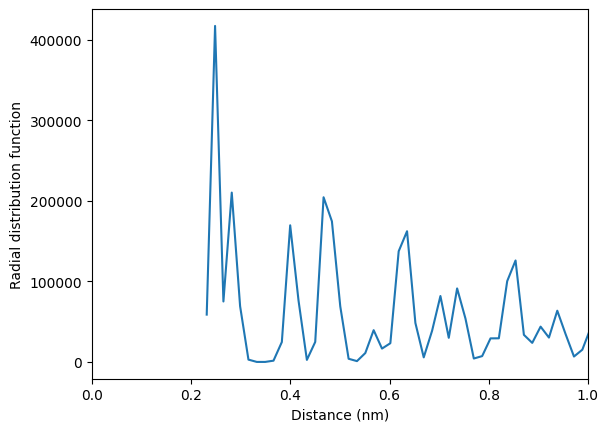

In [14]:
# colab AI wrote:
# prompt: in radial distribution, exclude distance= 0, means distance of self-atom

def radial_distribution(x, y, z, r_max=10, bins=50):
  """
  Calculates the radial distribution function of a set of particles.

  Args:
      x: The x-coordinates of the particles.
      y: The y-coordinates of the particles.
      z: The z-coordinates of the particles.
      r_max: The maximum distance to consider (in nm).
      bins: The number of bins to use.

  Returns:
      A tuple containing the radial distribution function and the bin centers.
  """

  # Calculate the distances between all pairs of particles
  distances = np.sqrt(np.square(np.subtract.outer(x, x)) +
                       np.square(np.subtract.outer(y, y)) +
                       np.square(np.subtract.outer(z, z)))

  # Exclude distance= 0, means distance of self-atom
  distances = distances[distances != 0]

  # Create a histogram of the distances
  hist, bin_edges = np.histogram(distances[distances < r_max], bins=bins)

  # Normalize the histogram by the volume of each bin
  bin_volumes = 4 * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3) / 3
  rdf = hist / bin_volumes

  # Calculate the bin centers
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

  return rdf, bin_centers

# plot the radial distribution function
rdf, bin_centers = radial_distribution(X, Y, Z, 5, 200)  # add manually - r_max=5, bins=200

plt.plot(bin_centers, rdf)
plt.xlabel("Distance (nm)")
plt.ylabel("Radial distribution function")
plt.xlim(0,1.0)
plt.show()